In [1]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math
import sys
sys.path.append('../')
from utils import visualize_data_sample
from sklearn.utils import shuffle
from keras.api.models import Model, Sequential
from keras.api.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Flatten, Softmax, Activation, MaxPool2D, Input, Dropout, ReLU, RandomBrightness, RandomContrast, RandomFlip, RandomZoom
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.api.metrics import Accuracy

In [2]:
x_data = np.load('../datasets/tp4/pipeline_images.npy')
y_data = np.load('../datasets/tp4/pipeline_predections.npy')

In [3]:
print(f'x_data shape : {x_data.shape}')
print(f'y_data shape : {y_data.shape}')

x_data shape : (1112, 228, 308, 3)
y_data shape : (1112, 4)


In [4]:
def print_angle_value(tan):
    print(f'rad value : {math.atan(tan)}')
    print(f'deg value : {math.degrees(math.atan(tan))}')

In [5]:
def preprocess_input(x_data):
    gray_images = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in x_data])
    gray_images = gray_images.astype('float32') / 255.0
    gray_images = np.expand_dims(gray_images, -1)
    
    return gray_images

In [6]:
def preprocess_output(y_data):
    y_data = y_data[:, 0:2]
    y_data[:, 0] = np.abs(y_data[:, 0])
    y_data[:, 0] = np.clip(y_data[:, 0], 0, 5)
    y_data[:, 1] = (y_data[:, 1] >= 0).astype(int)
    return y_data

In [7]:
x_data = preprocess_input(x_data)
y_data = preprocess_output(y_data)

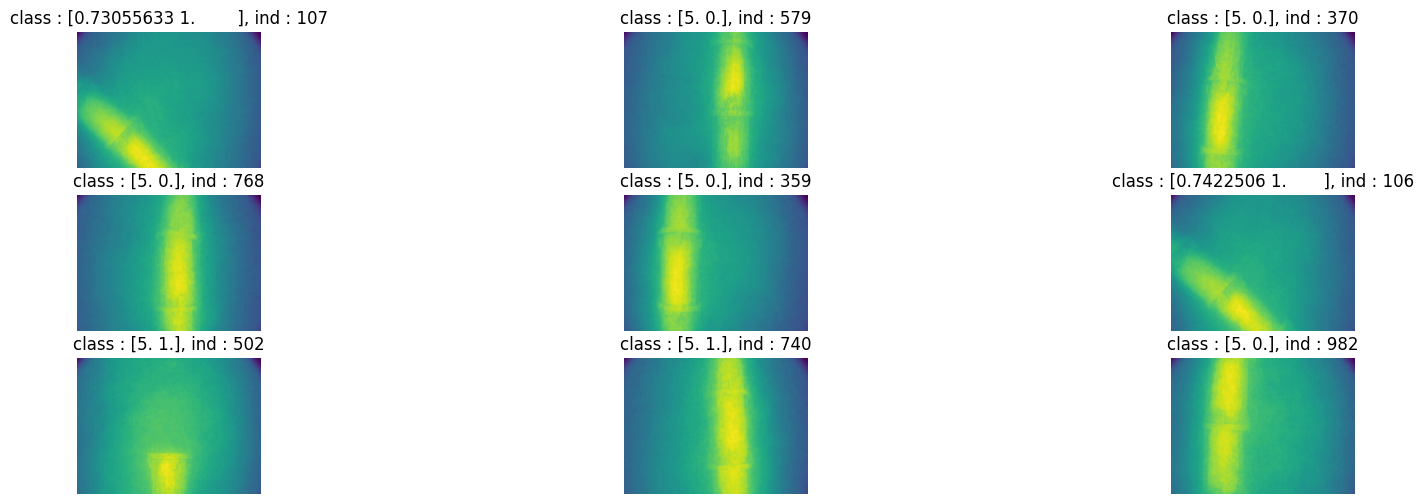

In [8]:
visualize_data_sample(x=x_data, y=y_data, random=True)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, shuffle=True)

In [10]:
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (889, 228, 308, 1)
x_test : (223, 228, 308, 1)
y_train : (889, 2)
y_test : (223, 2)


In [11]:
print(print_angle_value(5))

rad value : 1.373400766945016
deg value : 78.69006752597979
None


In [56]:
data_augmentation = Sequential([
    RandomContrast(factor=0.001),
    RandomBrightness(factor=0.001),
    RandomZoom(height_factor=(0.5, 0.5), width_factor=(0.5,0.5))   
])

(<Axes: >, <matplotlib.image.AxesImage at 0x169923aefa0>)

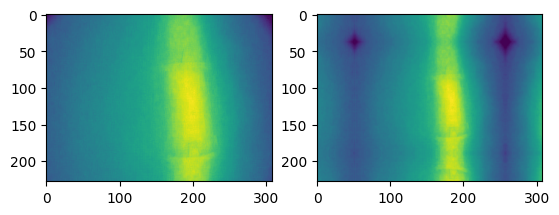

In [75]:
image = x_train[0]
augmented_image = data_augmentation(image)
plt.subplot(121), plt.imshow(image)
plt.subplot(122), plt.imshow(augmented_image)

In [13]:
input = Input((228, 308, 1))
x = data_augmentation(input)

x = Conv2D(filters=32, kernel_size=3, strides=2)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=16, kernel_size=3, strides=1)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=8, kernel_size=3, strides=1)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)


x = Flatten()(x)

x = Dense(8)(x)
x = BatchNormalization()(x)
x = ReLU()(x)


classification = Dense(1, activation='sigmoid', name='classification')(x)

regression = Dense(1, name='regression')(x)


model = Model(inputs=input, outputs=[classification, regression])

In [14]:
model.summary()
opt = Adam(learning_rate=0.0005)
model.compile(
    optimizer=opt,
    loss={'classification': 'binary_crossentropy', 'regression': 'mean_squared_error'},
    metrics={'classification': 'accuracy', 'regression': 'mean_absolute_error'},
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 228, 308,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 228, 308,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 113, 153,  │        320 │ sequential[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 113, 153,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 113, 153,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 76,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 54, 74,    │      4,624 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 74,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 54, 74,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 27, 37,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 25, 35, 8) │      1,160 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 35, 8) │         32 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 25, 35, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 17, 8) │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1632)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │     13,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 8)         │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 19,442 (75.95 KB)

 Trainable params: 19,314 (75.45 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
history = model.fit(
    x=x_train,
    y=[y_train[:, 1].reshape((-1,1)), y_train[:, 0].reshape((-1,1))],
    batch_size=16, 
    epochs=15
)

Epoch 1/15


In [36]:
model.evaluate(
    x=x_test,
    y=[y_test[:, 1].reshape((-1,1)), y_test[:, 0].reshape((-1,1))]
)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - classification_accuracy: 0.5610 - classification_loss: 0.6889 - loss: 2.8082 - regression_loss: 2.1192 - regression_mean_absolute_error: 0.9917


[2.776674509048462,
 0.6953643560409546,
 2.080946445465088,
 0.5470852255821228,
 0.9863070249557495]

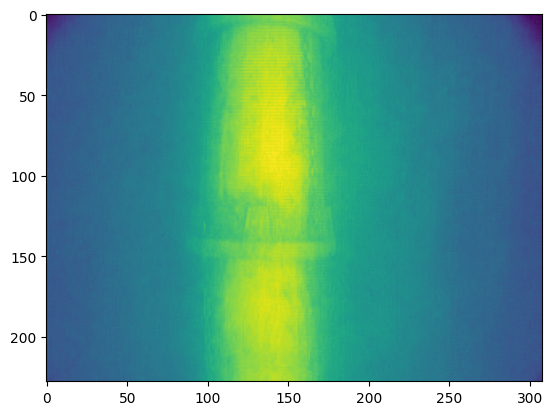

In [37]:
for img in x_test[:, 9]:
    plt.imshow(x_test[10])

In [31]:
history = history.history

(<Axes: title={'center': 'classification loss'}>,
 Text(0.5, 1.0, 'classification loss'))

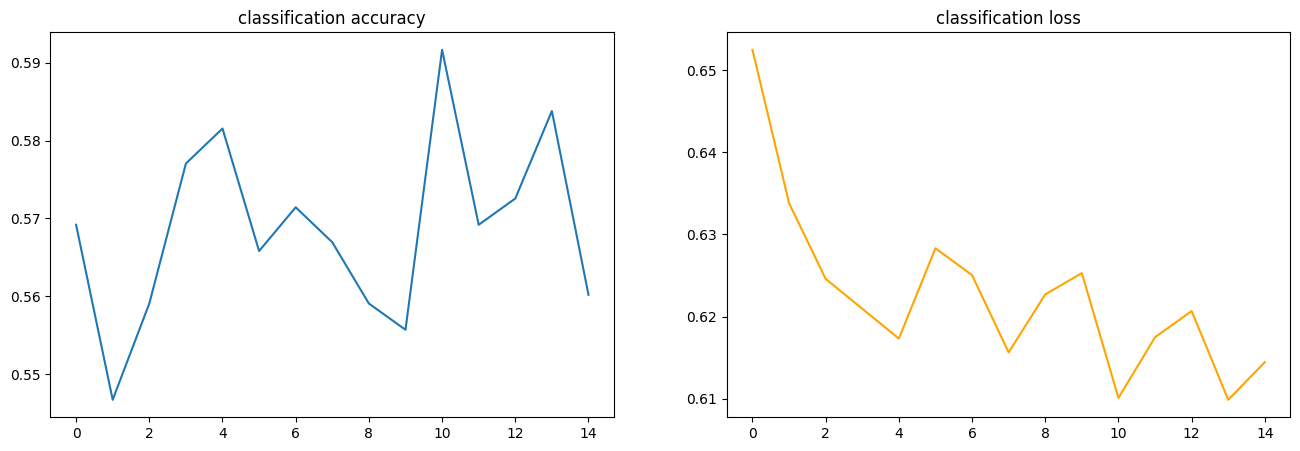

In [32]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1), plt.plot(history['classification_accuracy']), plt.title('classification accuracy')
plt.subplot(1,2,2), plt.plot(history['classification_loss'],color='orange'), plt.title('classification loss')

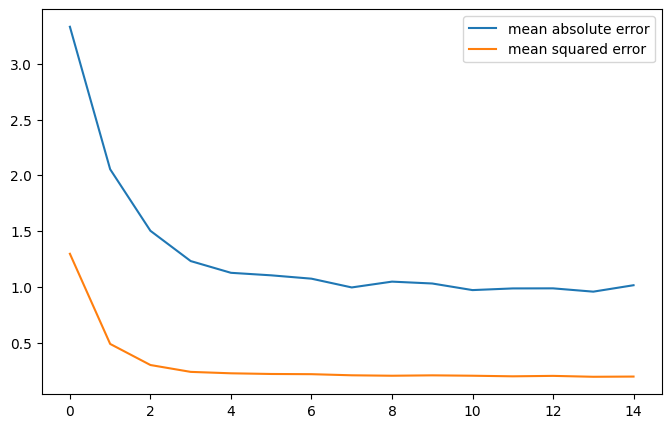

In [33]:
plt.figure(figsize=(8,5))
plt.plot(history['regression_mean_absolute_error'], label='mean absolute error')
plt.plot(history['regression_loss'], label='mean squared error')
plt.legend()


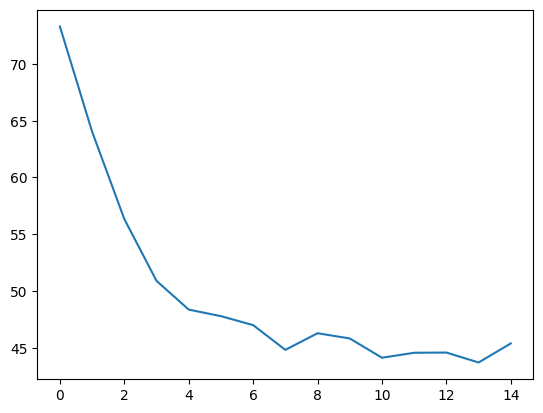

In [34]:
plt.plot(np.degrees(np.arctan(history['regression_mean_absolute_error'])), label='mean absolute error in degree')